![Py4Eng](img/logo.png)

# Feed Forward Network
## Yoav Ram

In this session we will understand:
- what feed forward networks are and how they work,
- how to back-propagate gradients in a multi-layer network
- how to efficiently fit multi-layer networks using adaptive gradient descent techniques
- how to feed backwards to generate instead of classify

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.special import logit, expit
import scipy.ndimage
import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

blue, green, red = sns.color_palette('muted', 3)
sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)

We start by loading the MNIST digits data we used in the [softmax model session](softmax-model.ipynb).

In [3]:
import keras
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

In [4]:
nsamples, width, height = X_train.shape
nfeatures = width * height
# reshape and normalize to (0, 1)
X_train = X_train.reshape(nsamples, nfeatures) / 255 
X_test = X_test.reshape(-1, nfeatures) / 255

In [5]:
# if we are already using keras, we can use it for one-hot encoding, too
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

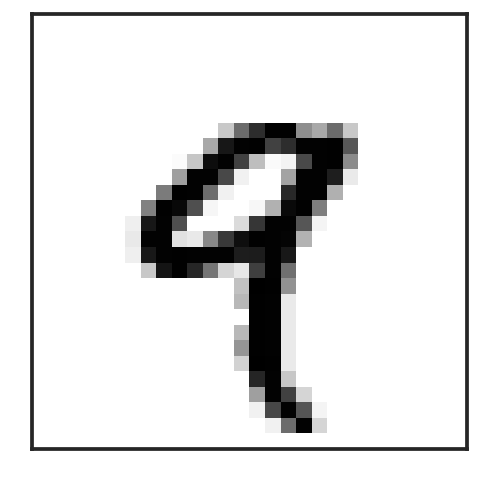

In [6]:
def display_image(im, ax=None):
    if ax is None: fig, ax = plt.subplots()
    ax.imshow(im.reshape((28, 28)), cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])
    
display_image(X_train[4])

With softmax regression we got accuracy of ~87% (or even up to 92% if we run it longer, see the scikit-learn example).
But we talked about the problems with logistic models and that it might be that the relationship between pixels and categories is not linear or even monotone.
We also discussed a way to overcome this issue - polynomial features.

Here we will use another solution - the layering or composition of several linear models.

The idea is that for an input (features) $\mathbf{X_1}$, the model we will use is:

$$
\mathbf{X_2} = f_1(\mathbf{X_1} \cdot  \mathbf{W_1}) \\
\mathbf{X_3} = f_2(\mathbf{X_2} \cdot  \mathbf{W_2}) \\
\ldots \\
\mathbf{\widehat Y} = f_{n}(\mathbf{X_n})
$$

We will fit this model to the data by looking for $\mathbf{W_1}, \ldots, \mathbf{W_n}$ that give us a good prediction.

This kind of model is called a **feed forward network**.

# Two layers FFN

We start with two layers - the readout layer is the softmax regression layer, and before that we will have a hidden layer that transforms the input features $\mathbf{X_1}$ into complex features $\mathbf{X_2}$: each feature in $\mathbf{X_2}$ is a combination of all features in $\mathbf{X_1}$.

We already implemented these functions in the previous session:

In [7]:
def random_matrix(ninputs, noutputs):
    boundary = np.sqrt(6 / (ninputs + noutputs))
    return np.random.uniform(-boundary, boundary, size=(ninputs, noutputs))

def softmax(x):
    expx = np.exp(x - x.max(axis=1, keepdims=True))
    return expx / expx.sum(axis=1, keepdims=True)

def accuracy(Yhat, Y):
    return (Yhat.argmax(axis=1) == Y.argmax(axis=1)).mean()

def cross_entropy(Yhat, Y):
    ylogy = Y * np.log(Yhat)
    return -ylogy.sum()

# Exercise: ReLU
The readout layer uses the softmax function $f_2(z)=softmax(z)$.
What about $f_1(z)$?

To add some non-linearity to the model, we want to use a non-linear function, usually called [*activation function*](https://en.wikipedia.org/wiki/Activation_function).
For ease of use, we want a differentiable function that's easy and efficient to compute.

There are several options we can use, and a common choise is the rectifier, or [*ReLU*](https://en.wikipedia.org/wiki/Rectifier_%28neural_networks%29) function:

$$
ReLU(x) = \cases{x, & if x>0 \\ 0, & if x < 0}
$$

with a derivative

$$
ReLU'(x) = \cases{1, & if x>0 \\ 0, & if x < 0}
$$

Implement these functions.

**Reminder**
- Edit cell by double clicking
- Run cell by pressing _Shift+Enter_
- Get autocompletion by pressing _Tab_
- Get documentation by pressing _Shift+Tab_

In [14]:
def ReLU(X):
    pass

def dReLU(X):
    pass

**Remember to remove the line starting with `%run...` otherwise you are running the official solution rather than yours.**

In [10]:
%run -i ../solutions/FFN.py

ReLU(np.random.uniform(-10, 10, 5))

array([2.65028962, 0.        , 0.        , 0.        , 0.        ])

In [11]:
arr = np.random.uniform(-10, 10, 5)
print(ReLU(arr))
print(dReLU(arr))

[9.23981399 0.16130646 1.94223069 0.         0.        ]
[1. 1. 1. 0. 0.]


# Dropout

A simple way to avoid overfitting is to use [*dropout*](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf): randomly ignoring some elements of every layer during training (but not during prediction).

In [12]:
def drop(X, keep_prob=1):
    if keep_prob < 1:
        X = X.copy() # we don't want to change X
        keeps = np.random.rand(X.shape[1]) < keep_prob
        # X.shape is (nsamples, nfeatures)
        X[:, ~keeps] = 0 # ignore
        X[:, keeps] *= (1/keep_prob) # normalize
    return X

# Feed Forward

Next, we want to write a function that for given input $\mathbf{X_1}$ calculates $\mathbf{\widehat Y}$.
But we also want to get all the intermediate layers, not just the final layer (the output, result of the readout layer).
The reason will become clear soon, when we write the back-propagation.

Prediction is then done by taking the last layer.

In [13]:
def feed_forward(Ws, X, keep_prob=1):
    X1 = X
    W1, W2 = Ws
    
    # hidden layer
    Z1 = X1 @ W1 
    Z1 = drop(Z1, keep_prob=keep_prob)
    X2 = ReLU(Z1) 
    
    # readout layer
    Z2 = X2 @ W2 
    Yhat = softmax(Z2) 
    return [X1, Z1, X2, Z2, Yhat]

def predict(Ws, X):
    if X.ndim == 1:
        X = np.expand_dims(X, 0)
    return feed_forward(Ws, X, keep_prob=1)[-1]

def display_prediction(idx):
    prediction = predict(Ws, X_test[idx, :]).argmax()
    print(prediction)
    return display_image(X_test[idx])

2


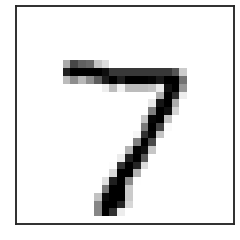

In [13]:
nhidden = 100
W1 = random_matrix(nfeatures, nhidden)
W2 = random_matrix(nhidden, ncats)
Ws = [W1, W2]

display_prediction(0)

# Exercise: feed-forward

Rewrite `feed_forward` using a `for` loop so that it would work for any number of hidden layers.

In [20]:
def feed_forward(Ws, X, keep_prob=1):
    pass

8


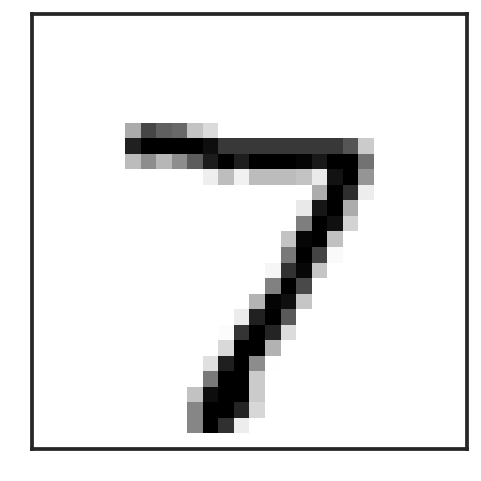

In [14]:
%run -i ../solutions/FFN.py

nhidden = 100
W1 = random_matrix(nfeatures, nhidden)
W2 = random_matrix(nhidden, ncats)
Ws = [W1, W2]

display_prediction(0)

# Back propagation

We now arrive at the most complicated and important part: the calculation of the gradeints of the loss function with respect to the $\mathbf{W_k}$ matrices - the model parameters, the weights of the network.

Since we use the softmax function, the loss function is still the cross-entropy function $\mathbf{J}(\mathbf{W_1}, \ldots, \mathbf{W_n} \mid \mathbf{X_1}, \mathbf{Y})$, the negative of the log-likelihood.

We know how to do gradient descent, but we need to calculate the gradient.
This seems at first very hard for a model as complex as:
$$
\mathbf{Z_1} = \mathbf{X_1} \cdot  \mathbf{W_1} \\
\mathbf{X_2} = f_1(\mathbf{Z_1}) \\
\mathbf{Z_2} = \mathbf{X_2} \cdot \mathbf{W_2} \\
\mathbf{X_3} = f_2(\mathbf{Z_2}) \\
\ldots \\
\mathbf{\widehat Y} = f_{n}(\mathbf{Z_n}) \\
\mathbf{J} = - \sum_{j=1}^{nsamples}{ \sum_{k=1}^{ncats}{y_{j,k} \log{\widehat y_{j,k}}} }
$$

But we actually know how to calculate the gradient at each layer $\frac{\partial \mathbf{X_k}}{\partial \mathbf{X_{k-1}}}$ so calculating the gradient with respect to any $\mathbf{W_k}$ is just a matter of applying the chain rule as many times as we need.

The idea is that we first calculate the loss function - **feed forward**.
Then we apply the chain rule in reverse iteration to calculate the gradient of the loss function $\mathbf{J}$ with respect to all $\mathbf{W_k}$.
Since the gradient at any layer is calculated as a function of the error measured in the previous layer, we essentially propagate the error backwards, thus the name for this algorithm - [**back propagation**](https://en.wikipedia.org/wiki/Backpropagation).

To calculate $\partial \mathbf{J}/\partial W_2$ we have the exact same calculation as in the [logistic](logistic-model.ipynb) or softmax model (makes sense as $\mathbf{W_2}$ is the softmax layer)

$$
\frac{\partial \mathbf{J}}{\partial W_2} = 
\frac{\partial \mathbf{J}}{\partial \widehat Y} \cdot \frac{\partial \widehat Y}{\partial Z_2} \cdot  \frac{\partial Z_2}{\partial W_2}
$$

To calculate $\partial \mathbf{J}/\partial \mathbf{W_1}$ (which is a matrix with the same number of entries as $\mathbf{W_1}$) we can use a similar but longer calculation as the readout layer:

$$
\frac{\partial \mathbf{J}}{\partial \mathbf{W_1}} = 
\frac{\partial \mathbf{J}}{\partial \mathbf{\widehat Y}} \cdot \frac{\partial \mathbf{\widehat Y}}{\partial \mathbf{Z_2}} \cdot \frac{\partial \mathbf{Z_2}}{\partial \mathbf{X_2}} \cdot \frac{\partial \mathbf{X_2}}{\partial \mathbf{Z_1}} \cdot \frac{\partial \mathbf{Z_1}}{\partial \mathbf{W_1}}
$$

Note that the first terms of this product were already calculated when calculating $\frac{\partial C}{\partial \mathbf{W_2}}$; the term 

$$
\delta_2 = \frac{\partial \mathbf{J}}{\partial \mathbf{\widehat Y}} \cdot \frac{\partial \mathbf{\widehat Y}}{\partial \mathbf{Z_2}}
$$

is considered the error of the previous layer, and it is back-propagated to the next layer:

$$
\frac{\partial \mathbf{J}}{\partial \mathbf{W_1}} = 
\delta_2 \cdot \frac{\partial \mathbf{Z_2}}{\partial \mathbf{X_2}} \cdot \frac{\partial \mathbf{X_2}}{\partial \mathbf{Z_1}} \cdot \frac{\partial \mathbf{Z_1}}{\partial \mathbf{W_1}}
$$

These are three easy opeations:
$$
\frac{\partial \mathbf{X_2}}{\partial \mathbf{Z_1}} = \frac{\partial ReLU{(\mathbf{Z_1})}}{\partial \mathbf{Z_1}} = ReLU'(\mathbf{Z_1}) \\
\frac{\partial \mathbf{Z_1}}{\partial \mathbf{W_1}}=\frac{\partial (\mathbf{X_1} \mathbf{W_1})}{\partial \mathbf{W_1}} = \mathbf{X_1} \\
\frac{\partial \mathbf{Z_2}}{\partial \mathbf{X_2}} = \frac{\partial (\mathbf{X_2} \mathbf{W_2})}{\partial \mathbf{X_2}} = \mathbf{W_2}
$$

In the next layer $\delta_1$ is updated to 
$$
\delta_1 = \delta_2 \cdot \frac{\partial \mathbf{Z_2}}{\partial \mathbf{X_2}} \cdot \frac{\partial \mathbf{X_2}}{\partial \mathbf{Z_1}} = \delta_2 \cdot W_2 \cdot Relu'(Z_1),
$$
thus *propagating back* the error $\delta$.

Consider that in forwarding we use the matrix multiplication to activate each node as a weighted average of the previous nodes (the weights given by $\mathbf{W_k}$). 
Back propagation can be considered the reverse operation.

The actual operators used below are chosen to avoid loops (except the loop through the layers which is unavoiable) and to keep the correct dimensions - see the discussion in the [softmax model session](softmax-model.ipynb#Gradient-descent).

In [15]:
def back_propagation(Ws, X, Y, keep_prob=1):
    W1, W2 = Ws
    X1, Z1, X2, Z2, Yhat = feed_forward(Ws, X, keep_prob=keep_prob)

    # readout layer
    δ2 = Yhat - Y # prediction error, dJ/dYhat * dYhat/dZ2 (-1, ncats)
    dW2 = X2.T @ δ2 # dJ/dW2 = δ2 * dZ2/dX2 = δ2 * X2

    # hidden layer
    δ1 = (δ2 @ W2.T) * dReLU(Z1) # δ1 = dJ/dX_2 = δ2 * dZ2/dX2 * dX2/dZ1 = δ2 * W2 * ReLU(Z1)
    dW1 = X1.T @ δ1 # dJ/dW1 = δ1 * dZ1/dW1 = δ1 * X1

    gradients = [dW1, dW2]
    # sanity checks
    assert len(gradients) == len(Ws), (len(gradients), len(Ws))
    for dW, W in zip(gradients, Ws):
        assert dW.shape == W.shape, (dW.shape, W.shape)
    return gradients

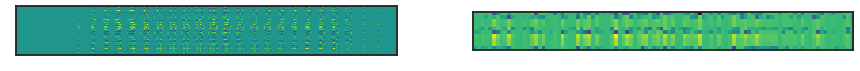

In [16]:
nhidden = 100
W1 = random_matrix(nfeatures, nhidden)
W2 = random_matrix(nhidden, ncats)
Ws = [W1, W2]

X, Y = X_train[:5, :], Y_train[:5, :]

dW1, dW2 = back_propagation(Ws, X, Y)
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
axes[0].imshow(dW1.T, cmap='viridis')
axes[1].imshow(dW2.T, cmap='viridis')
axes[0].set(xticks=[], yticks=[])
axes[1].set(xticks=[], yticks=[]);

# Gradient checking

Writing and implementing the gradient computation can be really hard.
But there is a good way to sanity-check that we made the correct computation.

Remember that the definition of a derivative is
$$
\frac{d f}{d x}\big(x\big) = \lim_{\Delta \to 0}{\frac{f(x+\Delta) - f(x-\Delta)}{2\Delta}}
$$
Therefore, we can compute the cross entropy at the params, then slightly change each parameter and compute the cross entropy again, and use these two computations as $f(x+\Delta)$ and $f(x-\Delta)$ where $x$ is the parameter we changed and $\Delta$ is the slight change. 
Then we can compare $\frac{f(x+\Delta)-f(x-\Delta)}{2\Delta}$ to the gradient computed by back propagation and check that the difference is very small.

In [16]:
def loss(Ws, X, Y):
    Yhat = predict(Ws, X)
    return cross_entropy(Yhat, Y)

def gradient_check(Ws, X, Y, Δ=1e-5):
    dWs = back_propagation(Ws, X, Y, keep_prob=1)
    Ws_ = [W.copy() for W in Ws]

    for i, (W_, dW_) in enumerate(zip(Ws_, dWs)):
        print('W{}'.format(i+1))
        for i in range(W_.shape[0]):
            for j in range(W_.shape[1]):
                dw = dW_[i, j]
                W_[i,j] += Δ
                loss1 = loss(Ws_, X, Y)
                W_[i,j] -= 2*Δ
                loss2 = loss(Ws_, X, Y)
                W_[i,j] += Δ
                dw_ = (loss1 - loss2) / (2 * Δ)
                rel_error = abs(dw - dw_) / abs(dw + dw_)
                if not np.isclose(dw_, dw):
                    print(i, j, dw, dw_, rel_error)

nhidden = 10
W1 = random_matrix(nfeatures, nhidden)
W2 = random_matrix(nhidden, ncats)
Ws = [W1, W2]
X, Y = X_train[:100,:], Y_train[:100,:]
gradient_check(Ws, X, Y)

W1


../solutions/FFN.py:20: RuntimeWarning: invalid value encountered in double_scalars
  # hidden layer


W2


# Exercise: back propagation

To make sure we understand back propagation, let's rewrite the `back_propagation` function with a `for` loop for networks with more than a single hidden layer.

To use a visual debugger, fire up [Spyder](https://pythonhosted.org/spyder/) (installed with Anaconda). Switch to Variable Explorer in top right window. Spyder IDE was made to resemble MATLAB. If you want something more Visual Studio-y try the excellent [PyCharm](https://www.jetbrains.com/pycharm/) from JetBrains.

In [18]:
%run -i ../solutions/FFN.py # replace this line with your code

In [20]:
# gradient check for 2 layers
nhidden = 10
W1 = random_matrix(nfeatures, nhidden)
W2 = random_matrix(nhidden, ncats)
Ws = [W1, W2]
X, Y = X_train[:100,:], Y_train[:100,:]
gradient_check(Ws, X, Y)

W1


../solutions/FFN.py:20: RuntimeWarning: invalid value encountered in double_scalars
  # hidden layer


W2


In [21]:
# gradient check for 3 layers
nhidden = 10
W1 = random_matrix(nfeatures, nhidden)
W2 = random_matrix(nhidden, nhidden)
W3 = random_matrix(nhidden, ncats)
Ws = [W1, W2, W3]
X, Y = X_train[:100,:], Y_train[:100,:]
gradient_check(Ws, X, Y)

W1


../solutions/FFN.py:20: RuntimeWarning: invalid value encountered in double_scalars
  # hidden layer


W2
W3


# Momentum gradient descent

There are many different ways to do stochastic gradient descent.
Some of the algorithms adapt the learning rate $\eta$ during training. 
The basic intuition is that when we are far from the minimum we want to advance in big steps and when we are near to the minimum we want to advance more carefully.

The first optimization method we will use was described in [Rumelhart, Hinton & Williams, 1986](http://www.nature.com/doifinder/10.1038/323533a0).
It is a momentum method, meaning that at each iteration (batch) the current update is calculated as a decaying average of the previous update and the current gradients:

$$
\Delta W \to \alpha \Delta W - \eta \frac{\partial J}{\partial W} \\
W \to W + \Delta W
$$

This works fine, sometimes, but not as good as other algorithms. It simple and easy to implement, though, and gives a good sense of what other momentum-based algorithms do.
See a [comparison of algorithms on MNIST](https://github.com/mazefeng/sgd-opt).

In [19]:
class MomentumOptimizer:
    def __init__(self, α=0.9, η=0.05):
        self.α = α
        self.η = η
        self.ΔWs = None

    def send(self, dWs):
        if self.ΔWs is None:
            self.ΔWs = [0] * len(dWs)
        
        self.ΔWs = [
            self.α * ΔW - self.η * dW
            for ΔW, dW in zip(self.ΔWs, dWs)
        ]
        
        for ΔW in self.ΔWs:
            assert np.isfinite(ΔW).all()
        return self.ΔWs

In [20]:
optimizer = MomentumOptimizer()
print(optimizer.send([0, 0, 0]))
print(optimizer.send([1, 1, 1]))
print(optimizer.send([1, 1, 1]))

[0.0, 0.0, 0.0]
[-0.05, -0.05, -0.05]
[-0.095, -0.095, -0.095]


# Adam optimizer

A more sophisticated optimizing algorithm is [Adam](https://arxiv.org/pdf/1412.6980v9.pdf).
The algorithm to calculate the learning rate is in the linked paper in *Algorithm 1*, and the code below uses a slightly different order of compuation for efficieny.

Intuitively, we calculate the weighted running averages of the gradients $\mathbf{m}$ and of the squared gradeints $\mathbf{v}$, with memory parameters $\beta_1, \beta_2$ such that the most recent gradient has a weight of $1-\beta_1$ and $1-\beta_2$:

$$
\mathbf{m} \to \beta_1 \mathbf{m} + (1-\beta_1) \frac{\partial C}{\partial \mathbf{W}} \\
\mathbf{v} \to \beta_2 \mathbf{v} + (1-\beta_2) \Big(\frac{\partial C}{\partial \mathbf{W}}\Big)^2
$$

The ratio of $\frac{\mathbf{m}}{\sqrt{\mathbf{v}}}$ is similar to a *signal-to-noise* ratio, and we use this ratio instead of the gradients in a gradient descent scheme to update the parameters $\mathbf{W}$:

$$
\mathbf{W} \to  \mathbf{W} - \alpha \frac{\mathbf{m}}{\sqrt{\mathbf{v}}}
$$

See the [paper by Kingma and Ba](https://arxiv.org/pdf/1412.6980v9.pdf) for more details and comparison to other optimization strategies.
We use **Algorithm 1** from [Kingma and Ba](https://arxiv.org/pdf/1412.6980v9.pdf).

In [21]:
def average(prev, curr, β):
    return [
        β * p + (1 - β) * c
        for p, c
        in zip(prev, curr)
    ]
    
class AdamOptimizer:
    def __init__(self, α=0.001, β1=0.9, β2=0.999, ϵ=1e-8):
        self.α = α
        self.β1 = β1
        self.β2 = β2
        self.ϵ = ϵ
        self.m = None
        self.v = None
        self.t = 0

    def send(self, gradients):
        if self.m is None:
            self.m = [0] * len(gradients)
        if self.v is None:
            self.v = [0] * len(gradients)

        self.t += 1
        αt = self.α * np.sqrt(1 - self.β2**self.t) / (1 - self.β1**self.t)
        self.m = average(self.m, gradients, self.β1)        
        self.v = average(self.v, (g*g for g in gradients), self.β2)

        updates = [-αt * mi / (np.sqrt(vi) + self.ϵ) for mi, vi in zip(self.m, self.v)]
        for upd in updates:
            assert np.isfinite(upd).all()
        return updates

In [22]:
optimizer = AdamOptimizer()
print(optimizer.send([0, 0, 0]))
print(optimizer.send([1, 1, 1]))
print(optimizer.send([1, 1, 1]))

[-0.0, -0.0, -0.0]
[-0.0007441365882503311, -0.0007441365882503311, -0.0007441365882503311]
[-0.0008584623637594434, -0.0008584623637594434, -0.0008584623637594434]


# Training the FFN

Our `Trainer` is a bit different now, as it calls the  optimizer at each step to determine the updates. Otherwise it's fairly similar to the one we used in the [softmax model session](softmax-model.ipynb#Training).

In [23]:
class Trainer:
    def __init__(self, X, Y, optimizer, batch_size=50, keep_prob=0.5):
        self.X = X
        self.Y = Y
        self.epochs = 0
        self.batches = 0
        self.batch_size = batch_size
        self.nsamples = X.shape[0]
        self.keep_prob = keep_prob
        self.optimizer = optimizer
        
    def train(self, Ws, debug=False):
        self.batches += 1
        self.epochs = self.batches * self.batch_size // self.nsamples
        
        # get next batch
        start = (self.batches * self.batch_size) % self.nsamples
        stop = start + self.batch_size
        batch_idx = range(start, stop)
        X_, Y_ = self.X[batch_idx, :], self.Y[batch_idx, :]
        
        # calculate gradients
        dWs = back_propagation(Ws, X_, Y_, keep_prob=self.keep_prob)
        
        # calculate updates
        ΔWs = self.optimizer.send(dWs)        

        # apply updates in place
        for W, ΔW in zip(Ws, ΔWs):
            W += ΔW
            
        # print once every epoch
        if self.batches * self.batch_size % self.nsamples == 0:
            acc = accuracy(predict(Ws, X_test), Y_test)
            print("Epoch {}, test accuracy: {}".format(self.epochs, acc))
            
        # debug by printing the gradients
        if debug:
            for dW in dWs:
                print('Batch {}: min={}, mean={}, max={}'.format(self.batches, dW.min(), dW.mean(), dW.max()))

Now we initialize two layers and calculate the inital accuracy.

The input layer has 728 features, "neurons" or pixels; the readout later has 10 (categories).
Let's set the hidden layer to have 100 "neurons".

In [26]:
nhidden = 100
W1 = random_matrix(nfeatures, nhidden)
W2 = random_matrix(nhidden, ncats)
Ws = [W1, W2]

acc = accuracy(predict(Ws, X_test), Y_test)
print("Accuracy ({}): {:.2f}".format(0, acc))

Accuracy (0): 0.12


The accuracy we get is something around 0.1, depending on the specific random values of `W1` and `W2`.

Let's train the model for some epochs (each time we go over all the images is called an *epoch*).

In [27]:
trainer = Trainer(X_train, Y_train, MomentumOptimizer())
while trainer.epochs < 3:
    trainer.train(Ws)

Epoch 1, test accuracy: 0.098
Epoch 2, test accuracy: 0.098
Epoch 3, test accuracy: 0.098


**Training doesn't work!**

Let's debug it by looking at the gradients.

In [28]:
W1 = random_matrix(nfeatures, nhidden)
W2 = random_matrix(nhidden, ncats)
Ws = [W1, W2]

trainer = Trainer(X_train, Y_train, MomentumOptimizer())
while trainer.batches < 5:
    trainer.train(Ws, debug=True)

Batch 1: min=-2.47174180510457, mean=0.016905120123504397, max=3.5208922713438597
Batch 1: min=-14.691501039457581, mean=-4.440892098500626e-18, max=11.674370275015502
Batch 2: min=-4.7997481458354345, mean=0.14599391822969782, max=10.800269713471332
Batch 2: min=-71.8480744343072, mean=-7.283063041541027e-17, max=276.9244006306848
Batch 3: min=-6.338264073065333, mean=0.37156164082338844, max=69.18781784500082
Batch 3: min=-243.8670533346285, mean=3.588240815588506e-16, max=996.0197790568853
Batch 4: min=-8.627585198938075, mean=2.031239315149076, max=457.0562688896354
Batch 4: min=-313.1030611291202, mean=3.557154570899002e-16, max=1075.4794806050224
Batch 5: min=-7.9658016040382185, mean=1.558404557282633, max=386.09410972738567
Batch 5: min=-203.59410057775554, mean=-1.1368683772161603e-16, max=816.3396126165646


**The gradients are exploding!**

This is a familiar problem with training neural networks.
We might be able to solve this by playing with the parameters of the momentum optimizer.

In [29]:
W1 = random_matrix(nfeatures, nhidden)
W2 = random_matrix(nhidden, ncats)
Ws = [W1, W2]

trainer = Trainer(X_train, Y_train, MomentumOptimizer(η=0.001))
while trainer.epochs < 5:
    trainer.train(Ws)

Epoch 1, test accuracy: 0.6627
Epoch 2, test accuracy: 0.571
Epoch 3, test accuracy: 0.3133
Epoch 4, test accuracy: 0.3086
Epoch 5, test accuracy: 0.1929


This is somewhat better, but the accuracy should not go down...

Fortunately, we can use the Adam optimizer, which usually doesn't require us to change its parameters.

In [30]:
W1 = random_matrix(nfeatures, nhidden)
W2 = random_matrix(nhidden, ncats)
Ws = [W1, W2]

acc = accuracy(predict(Ws, X_test), Y_test)
print("Epoch 0, test accuracy: {:.2f}".format(acc))

trainer = Trainer(X_train, Y_train, AdamOptimizer())
while trainer.epochs < 10:
    trainer.train(Ws)

Epoch 0, test accuracy: 0.09
Epoch 1, test accuracy: 0.9193
Epoch 2, test accuracy: 0.9238
Epoch 3, test accuracy: 0.93
Epoch 4, test accuracy: 0.9357
Epoch 5, test accuracy: 0.9211
Epoch 6, test accuracy: 0.9197
Epoch 7, test accuracy: 0.9264
Epoch 8, test accuracy: 0.9315
Epoch 9, test accuracy: 0.9294
Epoch 10, test accuracy: 0.9379


So with Adam we got a rapid and significant increase in accuracy over the single-layer softmax model, which was ~89% after 10 epochs.

0


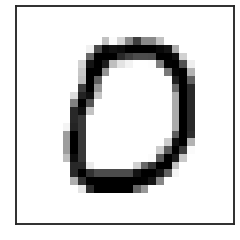

In [31]:
display_prediction(10)

# Saving the model

Saving the model is just a matter of saving `Ws` using NumPy's pickling function:

In [45]:
if input("Are you sure?") == 'y':
    np.savez_compressed('../data/FFN_MNIST_2layer.npz', Ws=Ws)

Are you sure? y


In [24]:
with np.load('../data/FFN_MNIST_2layer.npz', allow_pickle=True) as d:
    Ws = d['Ws']

6


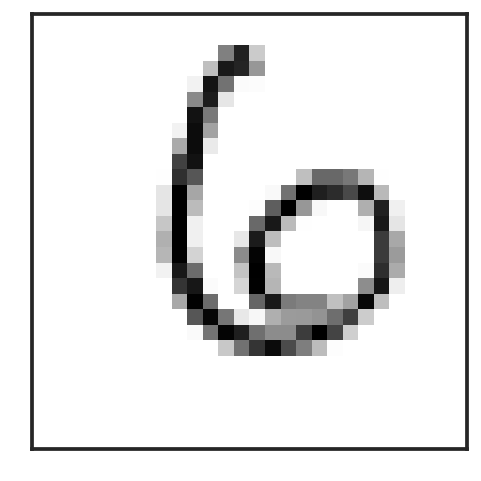

In [25]:
display_prediction(100)

# Loss landscape

We can't possibly plot the whole loss landscape, as the networks has too many parameters

In [29]:
print("Number of parameters:", sum([W.size for W in Ws]))

Number of parameters: 79400


An interesting practice, however, is to take a random initial guess of the model parameters $W^0$, and plot the trajectory from that point to the final minimum point $W^*$.

In [113]:
W0s = [
    random_matrix(nfeatures, nhidden),
    random_matrix(nhidden, ncats)
]
for W0, W in zip(W0s, Ws):
    assert W0.shape == W.shape

Now we compute and plot the loss on the test set along the trajectory from $W^0$ to $W^*$.

In [116]:
αs = np.linspace(0, 1, 50)
losses = np.zeros_like(αs)
for i, α in enumerate(αs):
    Ws_ = [(1-α) * W0 + α * W for W0, W in zip(W0s, Ws)]
    Yhat = predict(Ws_, X_test)
    losses[i] = cross_entropy(Yhat, Y_test)

(0, 1)

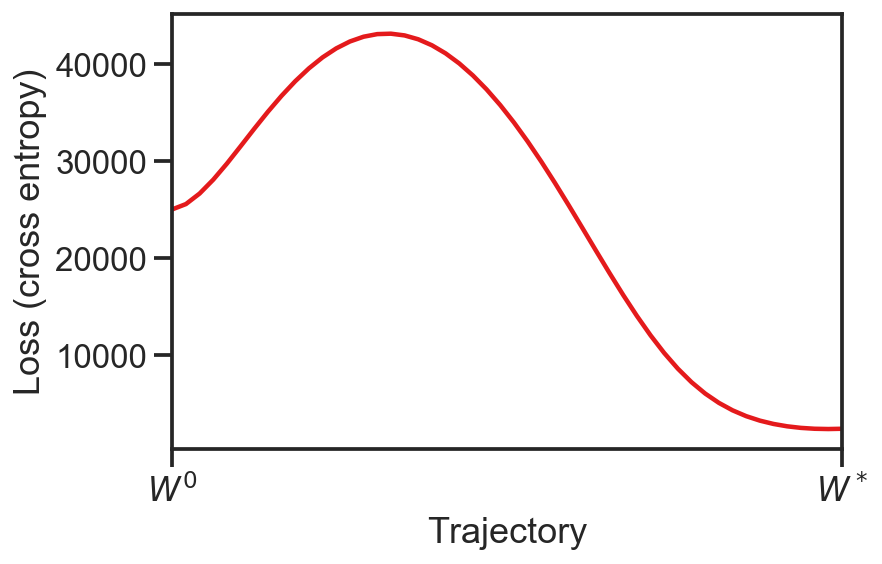

In [117]:
plt.plot(αs, losses, '-')
plt.xticks([0, 1], [r'$W^0$', r'$W^*$'])
plt.xlabel('Trajectory')
plt.ylabel('Loss (cross entropy)')
plt.xlim(0, 1)
# plt.yscale('log')

This illustrates that to the non-convexity of the loss landscape: to get from the initial guess to the final solution using gradient descent, the optimizer must first go "up" in order to go down.

See this paper for more on visualizing loss landscapes:
> Li H, Xu Z, Taylor G, Studer C, Goldstein T. [Visualizing the loss landscape of neural nets](https://arxiv.org/abs/1712.09913). Adv Neural Inf Process Syst. 2018

# Confusion

We can also explore the confusion matrix to see which digits are commonly confused with which digits.

In [118]:
y_true = Y_test.argmax(axis=1)
y_pred = predict(Ws, X_test).argmax(axis=1)

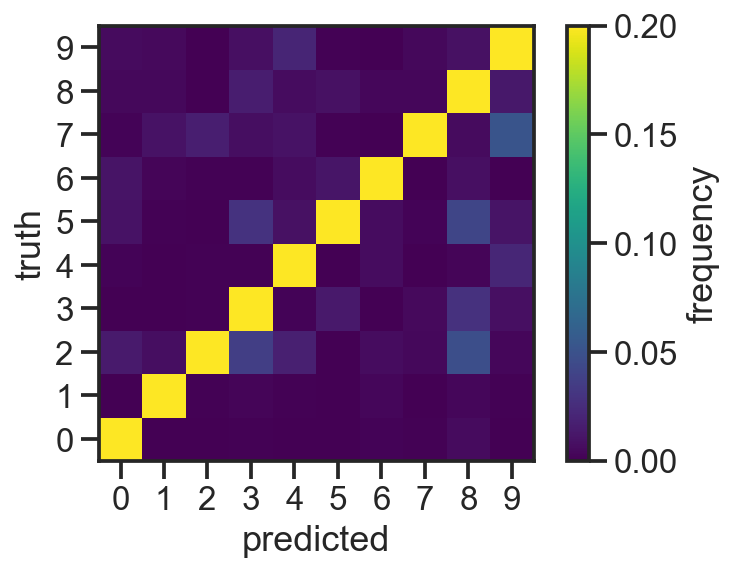

In [119]:
conf = confusion_matrix(y_true, y_pred, normalize='pred')
plt.imshow(conf, origin=(0,0), cmap='viridis', vmin=0, vmax=0.2)
plt.xlabel('predicted')
plt.ylabel('truth');
plt.xticks(range(10))
plt.yticks(range(10))
plt.colorbar(label='frequency');

Here we explore specific cases of confusion.

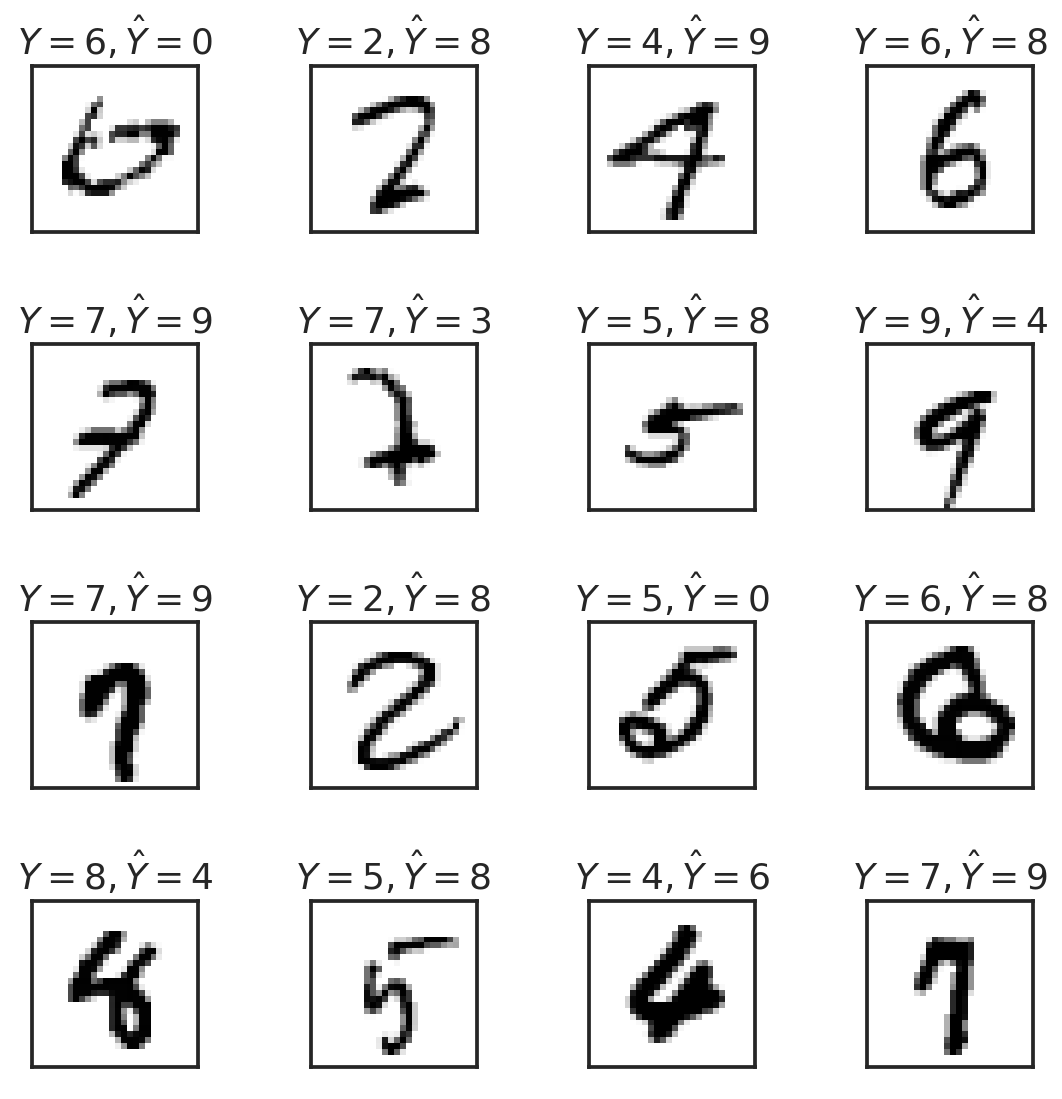

In [147]:
num_cols = 4

idx = y_pred != y_true
choices = np.random.choice(range(idx.size), size=num_cols*num_cols, replace=False, p=idx/idx.sum())

fig, axes = plt.subplots(num_cols, num_cols, figsize=(2*num_cols, 2*num_cols))
for i in range(num_cols):
    for j in range(num_cols):
        choice = choices[i*num_cols+j]
        display_image(X_test[choice], ax=axes[i,j])
        axes[i,j].set_title('$Y={}, \hat Y={}$'.format(y_true[choice], y_pred[choice]))
fig.tight_layout()

# Problems

One major problem is that FFN learns the relationship $W_{k,j}$ between pixel (feature) $x_j$ and digit (category) $k$, but if we move the pixels around without changing the category, the relationship is lost.
The model sees the features as a sequence of length 728, and it doesn't "know" that it's actually a 2D matrix of 28x28.

Because of that, it can't tell that a shifted 5 is still a 5.

In [48]:
with np.load('../data/FFN_MNIST_2layer.npz', allow_pickle=True) as d:
    Ws = d['Ws']

5


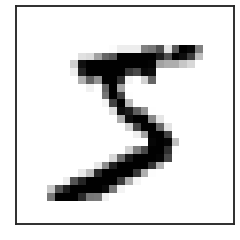

In [49]:
im = X_train[0]
print(predict(Ws, im).argmax())
display_image(im)

`scipy.ndimage` has a bunch of useful image analysis functions, but also see *scikit-image*.

3


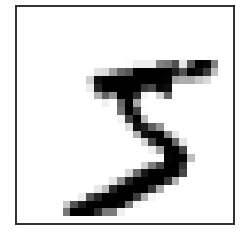

In [53]:
shifted = scipy.ndimage.shift(im.reshape((28, 28)), 2)
print(predict(Ws, shifted.ravel()).argmax())
display_image(shifted)

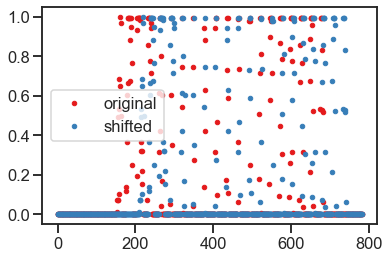

In [54]:
plt.plot(im.ravel(), '.', label='original')
plt.plot(shifted.ravel(), '.', label='shifted')
plt.legend();

A solution to this, which also offers other benefics such as faster training and more efficient memory use, is the use of *convolutional neural networks*, which use convolutions instead of fully connected (matrix multiplcation) layers.
We will deal with such networks in [another session](CNN.ipynb).

# Exercise

Train a model and use it as a [generative model](../exercises/FFN_GenModel.ipynb).

# References

- [Deep Learning by Ian Goodfellow and Yoshua Bengio and Aaron Courville](http://www.deeplearningbook.org), ch. 6, 7.12, and 8 - offers a comprehensive introduction to the subject.
- [Deep Learning: Technical introduction by Thomas Epelbaum](https://github.com/tomepel/Technical_Book_DL), ch. 4 - offers a very technical perspective with full derivation of all the formulas.

Both books are available online for free.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Data Science with Python_](https://python.yoavram.com/Deep4Devs) workshops.

The notebook was written using [Python](http://python.org/) 3.6.3, [IPython](http://ipython.org/) 6.2.1, [Jupyter](http://jupyter.org) 5.1.0.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)